<a href="https://colab.research.google.com/github/nikitakaraevv/deepfake-detection/blob/master/nbs/Colab_ds_preproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline submission using Fastai1




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install fastai
!pip install path;

### Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
from path import Path
from fastai.vision import *
from fastai.metrics import error_rate

bs = 64

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [0]:
bs = 64

Data preprocessing part was used create the dataset, now it can be ignored


### Data preprocessing

In [0]:
import glob

In [0]:
RANDOM_STATE=666

In [0]:
INPUT_DIR = "/content/drive/My Drive/DeepFakeDetection/data/unzipped_data/"
d = "/content/drive/My Drive/DeepFakeDetection/data"

In [19]:
df_meta = pd.read_feather(d+'/metadata.feather');
df_meta.columns = ['filename', 'label', 'split', 'original', 'chunk', 'cluster']
df_meta.head()

filename label  split        original  chunk  cluster
0  zhmjtavtpn.mp4  FAKE  train  ejnrxekehh.mp4     34        1
1  dazellwbsl.mp4  FAKE  train  xuxkfhqjiu.mp4     34        0
2  elwdztqnot.mp4  FAKE  train  xlyxbyhjsq.mp4     34        0
3  fiedwlcwyn.mp4  FAKE  train  skhnvzyukn.mp4     34        1
4  svbcewtjvh.mp4  FAKE  train  arrpqqfiah.mp4     34        1

In [20]:
df_meta.columns 

Index(['filename', 'label', 'split', 'original', 'chunk', 'cluster'], dtype='object')

In [21]:
df_meta.iloc[:,0]

0         zhmjtavtpn.mp4
1         dazellwbsl.mp4
2         elwdztqnot.mp4
3         fiedwlcwyn.mp4
4         svbcewtjvh.mp4
               ...      
119149    tzwywrsuvl.mp4
119150    kwxnrrocnb.mp4
119151    qitydywudu.mp4
119152    rjzzbkhgih.mp4
119153    iclrzgdndu.mp4
Name: filename, Length: 119154, dtype: object

In [22]:
len(df_meta)

119154

In [13]:
all_train_dirs = glob.glob(INPUT_DIR + 'dfdc_train_part_*')
for i, train_dir in enumerate(sorted(all_train_dirs)):
    print('[{:02}]'.format(i), train_dir)

[00] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_0
[01] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_08
[02] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_1
[03] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_10
[04] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_13
[05] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_14
[06] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_2
[07] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_3
[08] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_36
[09] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_37
[10] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfdc_train_part_38
[11] /content/drive/My Drive/DeepFakeDetection/data/unzipped_data/dfd

In [0]:
all_dataframes = []
for train_dir in all_train_dirs:
    df = pd.read_json(Path(train_dir)/'metadata.json', orient='index')
    df['filename'] = df.index
    df = df.reset_index(drop=True)
    df['path'] = df['filename'].apply(lambda x: Path(train_dir.split('/')[-1])/x.split('.')[0])
    all_dataframes.append(df)

train_df = pd.concat(all_dataframes, ignore_index=True, sort=False)

In [0]:
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(str(INPUT_DIR/x)+'.mp4'))].reset_index(drop=True)

In [16]:
train_df

label        original  ...        filename                           path
0      FAKE  xugmhbetrw.mp4  ...  aaqaifqrwn.mp4   dfdc_train_part_0/aaqaifqrwn
1      REAL             NaN  ...  aayrffkzxn.mp4   dfdc_train_part_0/aayrffkzxn
2      FAKE  aayrffkzxn.mp4  ...  abhggqdift.mp4   dfdc_train_part_0/abhggqdift
3      FAKE  fzvpbrzssi.mp4  ...  acagallncj.mp4   dfdc_train_part_0/acagallncj
4      FAKE  qyqufaskjs.mp4  ...  acdkfksyev.mp4   dfdc_train_part_0/acdkfksyev
...     ...             ...  ...             ...                            ...
26579  FAKE  gcxexbsvot.mp4  ...  ywpjoyxbdb.mp4  dfdc_train_part_42/ywpjoyxbdb
26580  FAKE  jkqvidhxwz.mp4  ...  yxbxemeatd.mp4  dfdc_train_part_42/yxbxemeatd
26581  FAKE  ncokiwnqdj.mp4  ...  zcxvjkexks.mp4  dfdc_train_part_42/zcxvjkexks
26582  FAKE  jkqvidhxwz.mp4  ...  zrduwhdxtm.mp4  dfdc_train_part_42/zrduwhdxtm
26583  FAKE  rqsfmrqnbx.mp4  ...  zyjguqtkks.mp4  dfdc_train_part_42/zyjguqtkks

[26584 rows x 5 columns]

In [0]:
res_df = pd.merge(df_meta, train_df[['filename','path']], on=['filename', 'filename'])

In [24]:
res_df

filename label  ... cluster                          path
0      oyixebfpcl.mp4  FAKE  ...      24  dfdc_train_part_4/oyixebfpcl
1      sayyjwtjol.mp4  REAL  ...      24  dfdc_train_part_4/sayyjwtjol
2      qxbnmwwgzp.mp4  FAKE  ...      24  dfdc_train_part_4/qxbnmwwgzp
3      puudvugxrl.mp4  REAL  ...      24  dfdc_train_part_4/puudvugxrl
4      shclgsfxtj.mp4  FAKE  ...      24  dfdc_train_part_4/shclgsfxtj
...               ...   ...  ...     ...                           ...
26579  cxbuowwwsr.mp4  FAKE  ...      -1  dfdc_train_part_1/cxbuowwwsr
26580  cktulounod.mp4  FAKE  ...     145  dfdc_train_part_1/cktulounod
26581  bkzrsfcrcr.mp4  FAKE  ...     730  dfdc_train_part_1/bkzrsfcrcr
26582  bwdmzwhdnw.mp4  FAKE  ...     730  dfdc_train_part_1/bwdmzwhdnw
26583  bfeewgzrbr.mp4  FAKE  ...     730  dfdc_train_part_1/bfeewgzrbr

[26584 rows x 7 columns]

In [25]:
df_fake = res_df[res_df["original"].isin(res_df['filename'])]
df_fake

filename label  ... cluster                           path
0      oyixebfpcl.mp4  FAKE  ...      24   dfdc_train_part_4/oyixebfpcl
2      qxbnmwwgzp.mp4  FAKE  ...      24   dfdc_train_part_4/qxbnmwwgzp
4      shclgsfxtj.mp4  FAKE  ...      24   dfdc_train_part_4/shclgsfxtj
5      rwnyguelho.mp4  FAKE  ...      28   dfdc_train_part_4/rwnyguelho
6      wfrkjyusxh.mp4  FAKE  ...      24   dfdc_train_part_4/wfrkjyusxh
...               ...   ...  ...     ...                            ...
26296  lxfrssijva.mp4  FAKE  ...     717  dfdc_train_part_47/lxfrssijva
26297  jbtxgmgqke.mp4  FAKE  ...     717  dfdc_train_part_47/jbtxgmgqke
26298  auxnjvttgs.mp4  FAKE  ...     717  dfdc_train_part_47/auxnjvttgs
26299  jutghbcklw.mp4  FAKE  ...     717  dfdc_train_part_47/jutghbcklw
26300  kwwveltzqp.mp4  FAKE  ...     717  dfdc_train_part_47/kwwveltzqp

[18734 rows x 7 columns]

In [0]:
df_fake=df_fake[df_fake.cluster!=-1]

In [27]:
df_fake = df_fake.drop_duplicates(subset='original', keep='first').reset_index(drop=True)
df_fake

filename label  ... cluster                           path
0     oyixebfpcl.mp4  FAKE  ...      24   dfdc_train_part_4/oyixebfpcl
1     qxbnmwwgzp.mp4  FAKE  ...      24   dfdc_train_part_4/qxbnmwwgzp
2     rwnyguelho.mp4  FAKE  ...      28   dfdc_train_part_4/rwnyguelho
3     wfrkjyusxh.mp4  FAKE  ...      24   dfdc_train_part_4/wfrkjyusxh
4     wqwsvsngjw.mp4  FAKE  ...      24   dfdc_train_part_4/wqwsvsngjw
...              ...   ...  ...     ...                            ...
3055  pbwkjxypwb.mp4  FAKE  ...     717  dfdc_train_part_47/pbwkjxypwb
3056  lhqzgsnvxw.mp4  FAKE  ...     718  dfdc_train_part_47/lhqzgsnvxw
3057  qsapwncedv.mp4  FAKE  ...     717  dfdc_train_part_47/qsapwncedv
3058  xtnfeuxmbc.mp4  FAKE  ...     717  dfdc_train_part_47/xtnfeuxmbc
3059  fmnpsjdxov.mp4  FAKE  ...     717  dfdc_train_part_47/fmnpsjdxov

[3060 rows x 7 columns]

In [0]:
#df_fake_sample = (df_fake.sample(5000, random_state = RANDOM_STATE)
#                  .reset_index(drop=True))

In [0]:
df_fake_sample = df_fake

In [29]:
len(set(df_fake_sample.original))

3060

In [0]:
# Install facenet-pytorch
!pip install /content/drive/My\ Drive/DeepFakeDetection/models/facenet-pytorch-vggface2/facenet_pytorch-2.0.0-py3-none-any.whl

from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p $torch_home/checkpoints/
!cp /content/drive/My\ Drive/DeepFakeDetection/models/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth $torch_home/checkpoints/vggface2_DG3kwML46X.pt
!cp /content/drive/My\ Drive/DeepFakeDetection/models/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth $torch_home/checkpoints/vggface2_G5aNV2VSMn.pt

Processing ./drive/My Drive/DeepFakeDetection/models/facenet-pytorch-vggface2/facenet_pytorch-2.0.0-py3-none-any.whl


## Face preprocessing

In [0]:
#from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import cv2
from PIL import Image, ImageDraw

In [0]:
margin = 32

In [0]:
mtcnn = MTCNN(margin=margin, keep_all=False, factor=0.4, device=device).eval()

In [0]:
# takes two filenames and compares fake frames to real ones of the original video. Then decides if fake or not
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    def __init__(self, detector, n_frames=None, batch_size=60, margin=0, threshold=1., image_mean = 40., resize=None):
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
        self.margin = margin
        self.threshold = threshold # this parameter allows to filter fakes with difference more than threshold from originals
        self.image_mean = image_mean # to consider the brightness of an image when filtering

    def extract_face_im(self, img, boxes, image_size=160, save_path=None):
        
        for i, box in enumerate(boxes):
            
            margin = [
                self.margin * (box[2] - box[0]) / (image_size - self.margin),
                self.margin * (box[3] - box[1]) / (image_size - self.margin),
            ]
            box = [
                int(max(box[0] - margin[0] / 2, 0)),
                int(max(box[1] - margin[1] / 2, 0)),
                int(min(box[2] + margin[0] / 2, img.size[0])),
                int(min(box[3] + margin[1] / 2, img.size[1])),
            ]

            face = img.crop(box).resize((image_size, image_size), 2)
            return face
        
    def __call__(self, fake_filename, real_filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        fake_cap = cv2.VideoCapture(fake_filename)
        real_cap = cv2.VideoCapture(real_filename)

        fake_len = int(fake_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        real_len = int(real_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        assert fake_len==real_len

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, real_len)
        else:
            sample = np.linspace(0, real_len - 1, self.n_frames).astype(int)

       
        def frame_process(v_cap, frames):
            success, frame = v_cap.retrieve()
            if not success: return False
                            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)

            # Resize frame to desired size
            if self.resize is not None:
                frame = frame.resize([int(d * self.resize) for d in frame.size])
            frames.append(frame)
            return True
        def get_fakes_reals(fake_faces, real_faces, threshold, image_mean):
            np_fakes = np.array([np.array(face) for face in fake_faces], dtype='int')
            np_reals = np.array([np.array(face) for face in real_faces], dtype='int')
            
            diff = image_mean * np.abs(np_fakes-np_reals) / np.mean(np_fakes)
            if threshold:
                try:
                    inds = np.where(np.mean(diff, axis=(1,2,3))>threshold)[0]
                    new_diff = diff[inds]
                    new_fake_faces = [fake_faces[ind] for ind in inds]
                    new_real_faces = [real_faces[ind] for ind in inds]
                    real_faces, fake_faces, diff = new_real_faces, new_fake_faces, new_diff
                except:
                    return [], []
       
            assert len(fake_faces)==len(real_faces)==len(diff)
            
            return fake_faces, real_faces
         # Loop through frames
        real_faces = []
        real_frames = []
        fake_frames = []
        fake_faces = []
        
        idx=0

        for j in range(fake_len):
            success = fake_cap.grab() and real_cap.grab()
            if j in sample:
                # Load frame
                if not frame_process(fake_cap, fake_frames): continue
                if not frame_process(real_cap, real_frames): continue

                # When batch is full, detect faces and reset frame list
                if len(fake_frames) % self.batch_size == 0 or j == sample[-1]:
                    boxes_vid, probs_vid = self.detector.detect(fake_frames)
                    
                    for boxes, probs, fake_frame, real_frame in zip(boxes_vid, probs_vid, fake_frames, real_frames):
                        
                        probs = np.array(probs)
                        if len(probs)>0 and (probs!=None).all() and (probs>0.95).all(): # take only faces in which the model is highly confident
                            fake_faces.append(self.extract_face_im(img=fake_frame, boxes=boxes))
                            real_faces.append(self.extract_face_im(img=real_frame, boxes=boxes))

                    fake_frames = []
                    real_frames = []
                            

        fake_cap.release()
        real_cap.release()
        fake_faces,  real_faces = get_fakes_reals(fake_faces, real_faces, threshold=self.threshold, image_mean=self.image_mean)
                            
        return fake_faces,  real_faces, fake_len 

In [0]:
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, n_frames=32, margin=32, threshold=1., resize=0.25)

In [0]:
sample = df_fake_sample.iloc[42]

In [0]:
fake_faces, real_faces, __ = detection_pipeline(str(INPUT_DIR/sample.path)+'.mp4', INPUT_DIR+str(sample.path).split('/')[0]+'/'+sample.original)

In [0]:
def show_diff(fake_faces, real_faces, threshold=None, filename=None):
    np_fakes = np.array([np.array(face) for face in fake_faces], dtype='int')
    np_reals = np.array([np.array(face) for face in real_faces], dtype='int')
    
    diff = 40*np.abs(np_fakes-np_reals) / np.mean(np_fakes)
    
    if threshold:
        inds = np.where(np.mean(diff,axis=(1,2,3))>threshold)[0]
        new_diff=diff[inds]
        new_fake_faces=[fake_faces[ind] for ind in inds]
        new_real_faces=[real_faces[ind] for ind in inds]
        real_faces, fake_faces, diff = new_real_faces, new_fake_faces, new_diff
       

    assert len(fake_faces)==len(real_faces)==len(diff)
    diff_show = np.clip(4*diff,0,255).astype('uint8')
    fig = plt.figure(figsize=(10,10*len(diff_show)))
    idx=0
    for i in range(len(diff_show)):
        ax1 = fig.add_subplot(len(diff_show)*3, 3, idx+1) # this line adds sub-axes
        ax2 = fig.add_subplot(len(diff_show)*3, 3, idx+2) 
        ax3 = fig.add_subplot(len(diff_show)*3, 3, idx+3) 

        idx+=3
        
        ax1.imshow(fake_faces[i] )
        ax2.imshow(real_faces[i] )
        ax3.imshow(Image.fromarray(diff_show[i]) )

        ax1.set_title("Fake")
        ax2.set_title("Real")
        ax3.set_title("Diff: "+ str(np.round(np.mean(diff[i]),3)))
    if filename:
        fig.savefig(filename)
    

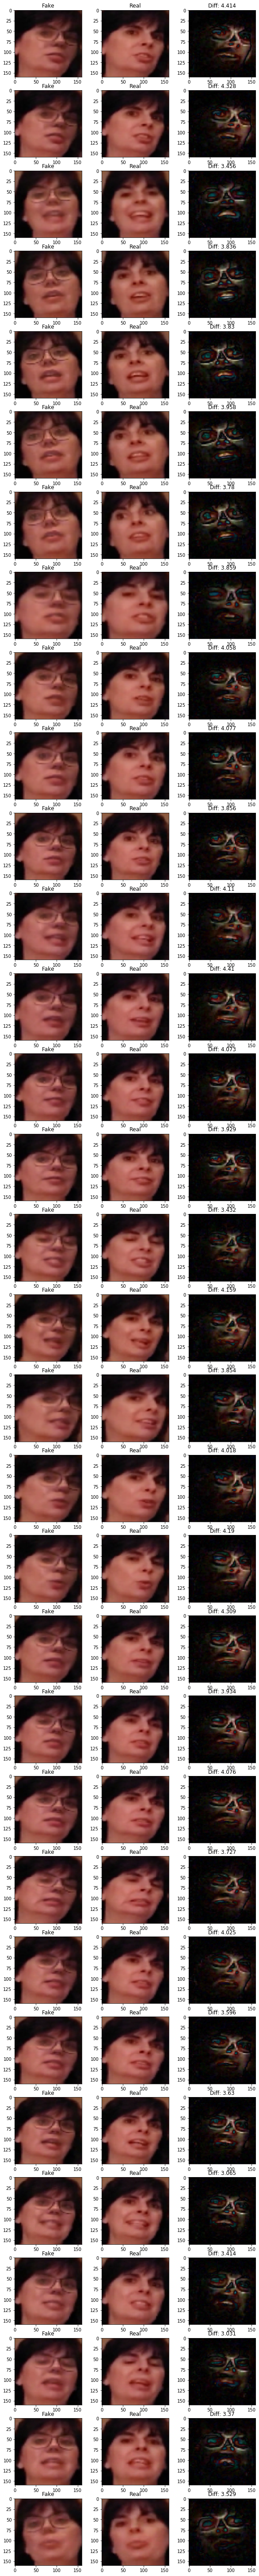

In [0]:
show_diff(fake_faces, real_faces) #threshold=2.) #filename=d+'/plots/fake_real_diff1.jpg')

In [0]:
df_fake_sample.head()

filename label  split  ... chunk  cluster                           path
0  tfilnvzecm.mp4  FAKE  train  ...    13      139  dfdc_train_part_13/tfilnvzecm
1  aywzfaodrz.mp4  FAKE  train  ...    13      139  dfdc_train_part_13/aywzfaodrz
2  whwgqnexeu.mp4  FAKE  train  ...     3      239   dfdc_train_part_3/whwgqnexeu
3  upikzruscn.mp4  FAKE  train  ...    10      139  dfdc_train_part_10/upikzruscn
4  qzisqairpe.mp4  FAKE  train  ...    13      139  dfdc_train_part_13/qzisqairpe

[5 rows x 7 columns]

In [0]:
os.listdir(d+'/filtered_ds_5000_fake_5000_real'+'/fake')

KeyboardInterrupt: ignored

In [0]:
for ind, sample in tqdm.tqdm_notebook(df_fake_sample.iterrows()):
    print(sample.path)
    video_name = str(sample.path).split('/')[1]

    fake_dir = d+'/filtered_ds_5000_fake_5000_real'+'/fake/'+video_name
    real_dir = d+'/filtered_ds_5000_fake_5000_real'+'/real/'+video_name   

    try: 
        os.mkdir(fake_dir)
        os.mkdir(real_dir)
    except: 
        print(f"directory {fake_dir} already exists")
        continue
    
    fake_faces, real_faces, video_len = detection_pipeline(str(INPUT_DIR/sample.path)+'.mp4', INPUT_DIR+'/'+str(sample.path).split('/')[0]+
                            '/'+sample.original)


    assert len(fake_faces)==len(real_faces)   
    faces_len = len(fake_faces)   
    if faces_len==0: continue
        
    for i in range(faces_len):
        frame_num = int(i * video_len / float(faces_len))
        fake_faces[i].save(fake_dir+'/im_'+str(frame_num)+'.jpg')
        real_faces[i].save(real_dir+'/im_'+str(frame_num)+'.jpg')
        

In [0]:
df_fake_sample['label'].replace({'FAKE': 1, 'REAL': 0}, inplace=True)

In [31]:
count_chunks = df_fake_sample.groupby('cluster').count().sort_values(by=['chunk']).chunk;
count_chunks

cluster
272      1
302      1
290      1
288      1
286      1
      ... 
714     65
656     67
423     68
139     87
4      125
Name: chunk, Length: 226, dtype: int64

In [32]:
count_chunks = count_chunks[(count_chunks>10) & (count_chunks<35)]; count_chunks

cluster
664    11
168    11
148    11
588    11
241    12
658    12
93     13
717    13
181    13
249    13
421    14
174    22
280    22
478    22
520    22
157    23
265    27
31     28
523    30
424    31
636    31
648    31
36     31
425    31
459    32
165    32
716    32
246    34
Name: chunk, dtype: int64

In [0]:
inds = df_fake_sample[(df_fake_sample.cluster.isin(count_chunks.keys())) & (df_fake_sample.chunk>40)].index

In [34]:
len(inds)

156

In [0]:
df_fake_sample.iloc[inds,2]='valid'

In [36]:
set(df_fake_sample.split)

{'train', 'valid'}

In [37]:
df_fake_sample.head()

filename label  split  ... chunk  cluster                          path
0  oyixebfpcl.mp4     1  train  ...     4       24  dfdc_train_part_4/oyixebfpcl
1  qxbnmwwgzp.mp4     1  train  ...     4       24  dfdc_train_part_4/qxbnmwwgzp
2  rwnyguelho.mp4     1  train  ...     4       28  dfdc_train_part_4/rwnyguelho
3  wfrkjyusxh.mp4     1  train  ...     4       24  dfdc_train_part_4/wfrkjyusxh
4  wqwsvsngjw.mp4     1  train  ...     4       24  dfdc_train_part_4/wqwsvsngjw

[5 rows x 7 columns]

In [38]:
df_fake_sample = df_fake_sample.reindex(np.random.permutation(df_fake_sample.index,))
print(df_fake_sample.shape)
df_fake_sample.head()

(3060, 7)


filename label  ... cluster                           path
1922  umoijebzjp.mp4     1  ...     523  dfdc_train_part_13/umoijebzjp
1950  gqbqhdfuid.mp4     1  ...     524  dfdc_train_part_13/gqbqhdfuid
997   sbvtjrwxng.mp4     1  ...     191   dfdc_train_part_3/sbvtjrwxng
1467  sxobmauqtc.mp4     1  ...     150  dfdc_train_part_46/sxobmauqtc
2886  ohjcblseuj.mp4     1  ...     714  dfdc_train_part_47/ohjcblseuj

[5 rows x 7 columns]

'My Drive/DeepFakeDetection/data'

In [50]:
os.listdir('/content/drive/My Drive/DeepFakeDetection/data/filtered_ds_5000_fake_5000_real/fake')

['zbmsvslybw',
 'ujhhksskil',
 'afvbadakux',
 'tlkynujfqr',
 'ojdeleaqdr',
 'bfljjbavig',
 'hournhdfpq',
 'hbuvmgbgzz',
 'dtsemuqyot',
 'kpspwqtytd',
 'ckzxmjrjvi',
 'cmyhcrqfnl',
 'dvlfqigkgr',
 'aabkwhhgwv',
 'ekyztqhbui',
 'aisdsiyxvh',
 'agetriarxi',
 'bfiimlamny',
 'cspbxdvhzz',
 'emjobuscyu',
 'bvfhvgdlnl',
 'ajpwtcvoqm',
 'dgzrkiuhre',
 'daityhferh',
 'bphndjivob',
 'crbieeifzf',
 'glsvewykpx',
 'evgzjtwveg',
 'gsnqvvauxc',
 'aqvywunszy',
 'aqipkezofh',
 'ebwirtdlkj',
 'gqzfzqemdg',
 'dkhdxcsjsk',
 'aimvdfybka',
 'gphrluouye',
 'bjqmdsvxxa',
 'bgxlldsfmx',
 'gcddjditsb',
 'cwupoiihky',
 'fweczwhjec',
 'eoetruoced',
 'gwpdxinfbc',
 'atksribkip',
 'fvpxbrdkpm',
 'hoafmkwlaw',
 'cwhitukhlh',
 'hhzhvvifat',
 'dhpjfcwifb',
 'cypzxddmmk',
 'fepcaxmpzk',
 'cmlmcdbwtg',
 'bhwujfazqy',
 'djkvxejnqm',
 'gumcnhxhju',
 'bjgobiieru',
 'giyrmesary',
 'azgnidjfzl',
 'bmejcmawty',
 'acjxjweexj',
 'fpamtxbdvu',
 'bwqfjaxyjb',
 'bortbfnubx',
 'dojorsyreo',
 'cwmidyiqvl',
 'agfivzlsgp',
 'dymuwnxx

In [47]:
os.listdir(fake_path)

['im_0.jpg',
 'im_10.jpg',
 'im_21.jpg',
 'im_32.jpg',
 'im_42.jpg',
 'im_53.jpg',
 'im_64.jpg',
 'im_75.jpg',
 'im_85.jpg',
 'im_96.jpg',
 'im_107.jpg',
 'im_117.jpg',
 'im_128.jpg',
 'im_139.jpg',
 'im_150.jpg',
 'im_160.jpg',
 'im_171.jpg',
 'im_182.jpg',
 'im_192.jpg',
 'im_203.jpg',
 'im_214.jpg',
 'im_225.jpg',
 'im_235.jpg',
 'im_246.jpg',
 'im_257.jpg',
 'im_267.jpg',
 'im_278.jpg',
 'im_289.jpg']

In [52]:
labels = []
paths = []
valid = []
j=0
for faken_, realn_, valid_ in zip(df_fake_sample.filename, df_fake_sample.original, df_fake_sample.split):
    fake_path = d+'/filtered_ds_5000_fake_5000_real'+'/fake/'+faken_[:-4]
    real_path = d+'/filtered_ds_5000_fake_5000_real'+'/real/'+faken_[:-4]
    fakenames = sorted(os.listdir(fake_path))
    realnames = sorted(os.listdir(real_path))
    assert len(fakenames)==len(realnames)
    for i in range(len(fakenames)):
        paths.append(Path(fake_path)/fakenames[i])
        labels.append(1)
        paths.append(Path(real_path)/realnames[i])
        labels.append(0)
        valid.append(valid_=='valid')
        valid.append(valid_=='valid')
    j+=1
    if j%20==0:
        print('It:', j, len(labels))
        print('It:', j, len(paths))

    

It: 20 986
It: 20 986
It: 40 2092
It: 40 2092
It: 60 3204
It: 60 3204
It: 80 4236
It: 80 4236
It: 100 5308
It: 100 5308
It: 120 6350
It: 120 6350
It: 140 7440
It: 140 7440
It: 160 8562
It: 160 8562
It: 180 9606
It: 180 9606
It: 200 10672
It: 200 10672
It: 220 11740
It: 220 11740
It: 240 12888
It: 240 12888
It: 260 14130
It: 260 14130
It: 280 15326
It: 280 15326
It: 300 16386
It: 300 16386
It: 320 17456
It: 320 17456
It: 340 18624
It: 340 18624
It: 360 19706
It: 360 19706
It: 380 20832
It: 380 20832
It: 400 21944
It: 400 21944
It: 420 22998
It: 420 22998
It: 440 24146
It: 440 24146
It: 460 25238
It: 460 25238
It: 480 26264
It: 480 26264
It: 500 27358
It: 500 27358
It: 520 28522
It: 520 28522
It: 540 29628
It: 540 29628
It: 560 30722
It: 560 30722
It: 580 31946
It: 580 31946
It: 600 33076
It: 600 33076
It: 620 34294
It: 620 34294
It: 640 35380
It: 640 35380
It: 660 36530
It: 660 36530
It: 680 37692
It: 680 37692
It: 700 38780
It: 700 38780
It: 720 39850
It: 720 39850
It: 740 40836
It: 74

In [53]:
new_df = pd.DataFrame(list(zip(paths, labels, valid)), 
               columns =['name', 'label', 'is_valid']) 
new_df

name  label  is_valid
0       /content/drive/My Drive/DeepFakeDetection/data...      1     False
1       /content/drive/My Drive/DeepFakeDetection/data...      0     False
2       /content/drive/My Drive/DeepFakeDetection/data...      1     False
3       /content/drive/My Drive/DeepFakeDetection/data...      0     False
4       /content/drive/My Drive/DeepFakeDetection/data...      1     False
...                                                   ...    ...       ...
167373  /content/drive/My Drive/DeepFakeDetection/data...      0     False
167374  /content/drive/My Drive/DeepFakeDetection/data...      1     False
167375  /content/drive/My Drive/DeepFakeDetection/data...      0     False
167376  /content/drive/My Drive/DeepFakeDetection/data...      1     False
167377  /content/drive/My Drive/DeepFakeDetection/data...      0     False

[167378 rows x 3 columns]

In [54]:
len(new_df)/2

83689.0

In [0]:
perm = list(np.random.permutation(int(len(new_df)/2)))
new_perm = []
for row in perm:
    new_perm.append(row*2)
    new_perm.append(row*2+1)

In [0]:
new_df = new_df.reindex(new_perm).reset_index(drop=True)

In [0]:
new_df.name = new_df.name.apply(lambda x: Path(str(x)[15:]))

In [58]:
new_df.head()

name  label  is_valid
0  My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
1  My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False
2  My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
3  My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False
4  My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False

In [61]:
d+'images_df'

'/content/drive/My Drive/DeepFakeDetection/dataimages_df'

In [0]:
new_df.to_csv(d+'images_df')

In [0]:
new_df = pd.read_csv(d+'/images_df');

In [0]:
del new_df['Unnamed: 0']

In [0]:
new_df

name  label  is_valid
0       My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
1       My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False
2       My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
3       My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False
4       My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
...                                                   ...    ...       ...
167373  My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False
167374  My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
167375  My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False
167376  My Drive/DeepFakeDetection/data/filtered_ds_50...      1     False
167377  My Drive/DeepFakeDetection/data/filtered_ds_50...      0     False

[167378 rows x 3 columns]

In [0]:
get_transforms(max_rotate=3.,max_warp=0.,p_affine=0.)

In [0]:
data

ImageDataBunch;

Train: LabelList (158948 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
1,0,1,0,1
Path: /content/drive;

Valid: LabelList (8430 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
1,0,1,0,1
Path: /content/drive;

Test: None

In [0]:
data = ((ImageList.from_df(df=new_df, 
                           path='/content/drive/')
                 .split_from_df()
                 .label_from_df(cols='label')
                 .transform(get_transforms(max_rotate=3.,max_warp=0.,p_affine=0.), size=160)
                 .databunch())
                 .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


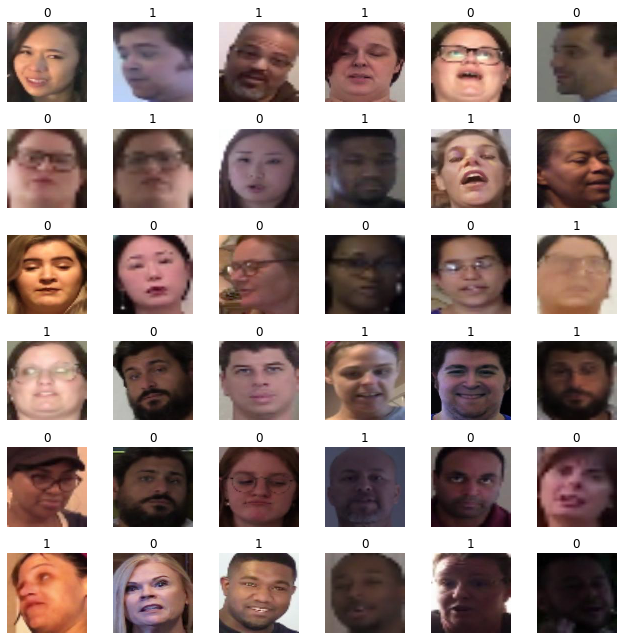

In [0]:
data.show_batch(rows=6, figsize=(9,9))


In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for roodt, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))


In [0]:
d+'/filtered_ds_5000_fake_5000_real'

'/content/drive/My Drive/DeepFakeDetection/data/filtered_ds_5000_fake_5000_real'

In [0]:
zipf = zipfile.ZipFile('ds.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir(d+'/filtered_ds_5000_fake_5000_real', zipf)
zipf.close()

KeyboardInterrupt: ignored

In [0]:
learn.fit_one_cycle(1)

KeyboardInterrupt: ignored

In [0]:
learn.export('/content/drive/My Drive/DeepFakeDetection/models/fastai/resnet18')

In [0]:
str(INPUT_DIR/sample.path)+'.mp4'

NameError: ignored

In [0]:
fake_cap = cv2.VideoCapture(str(INPUT_DIR/sample.path)+'.mp4')
fake_len = int(fake_cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [0]:
real_cap = cv2.VideoCapture(INPUT_DIR+'/'+str(sample.path).split('/')[0]+
                            '/'+sample.original)
real_len = int(fake_cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [0]:
train_df['label'].replace({'FAKE': 1, 'REAL': 0}, inplace=True)

In [0]:
train_df.head()

label        original  split        filename                          path
0      1  xugmhbetrw.mp4  train  aaqaifqrwn.mp4  dfdc_train_part_0/aaqaifqrwn
1      0             NaN  train  aayrffkzxn.mp4  dfdc_train_part_0/aayrffkzxn
2      1  aayrffkzxn.mp4  train  abhggqdift.mp4  dfdc_train_part_0/abhggqdift
3      1  fzvpbrzssi.mp4  train  acagallncj.mp4  dfdc_train_part_0/acagallncj
4      1  qyqufaskjs.mp4  train  acdkfksyev.mp4  dfdc_train_part_0/acdkfksyev

In [0]:
meta = pd.read_json("metadata.json", orient='index'); meta.head(5)

label        original  split
aaqaifqrwn.mp4  FAKE  xugmhbetrw.mp4  train
aayrffkzxn.mp4  REAL             NaN  train
abhggqdift.mp4  FAKE  aayrffkzxn.mp4  train
acagallncj.mp4  FAKE  fzvpbrzssi.mp4  train
acdkfksyev.mp4  FAKE  qyqufaskjs.mp4  train

In [0]:
len(meta)

1334

In [0]:
meta_real = meta[meta.label!="FAKE"]; meta_real.head()

label original  split
aayrffkzxn.mp4  REAL      NaN  train
apedduehoy.mp4  REAL      NaN  train
apvzjkvnwn.mp4  REAL      NaN  train
chqqxfuuzi.mp4  REAL      NaN  train
ddtbarpcgo.mp4  REAL      NaN  train

In [0]:
meta_fake =  meta[meta.label=="FAKE"].sample(87,random_state=0); meta_fake.head()

label        original  split
petmyhjclt.mp4  FAKE  ddtbarpcgo.mp4  train
scxgpnknil.mp4  FAKE  yxvmusxvcz.mp4  train
ealulizawd.mp4  FAKE  psjfwjzrrh.mp4  train
wjypybysuw.mp4  FAKE  jzupayeuln.mp4  train
alpkghdgrv.mp4  FAKE  wynotylpnm.mp4  train

In [0]:
list(meta_fake.index)[:5]

['petmyhjclt.mp4',
 'scxgpnknil.mp4',
 'ealulizawd.mp4',
 'wjypybysuw.mp4',
 'alpkghdgrv.mp4']

In [0]:
data_dir = Path("/content/drive/My Drive/DeepFakeDetection/data")

In [0]:
def move_files(dir_from, dir_to, f):
    for fn in os.listdir(dir_from):
        if f(fn): os.rename(dir_from/fn, dir_to/fn)

In [0]:
def is_fake(fn): return fn[:-4]+'.mp4' in meta_fake.index
def is_real(fn): return not is_fake(fn)

In [0]:
move_files(data_dir/"initial_downloads"/"faces",
           data_dir/"small_ds_80_Fake_80_Real"/"train"/"real",
           is_real)

In [0]:
%cd ..

/content/drive/My Drive/DeepFakeDetection/data/small_ds_80_Fake_80_Real/train


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(os.listdir('real'), test_size=0.3, random_state=42)

In [0]:
print(len(X_train), len(X_test))

60 26


In [0]:
move_files(data_dir/"small_ds_80_Fake_80_Real"/"train"/"real",
           data_dir/"small_ds_80_Fake_80_Real"/"valid"/"real",
           lambda x: x in X_test)

In [0]:
len(os.listdir('../valid/real'))

26

In [0]:
X_train, X_test = train_test_split(os.listdir('fake'), test_size=0.3, random_state=42)

In [0]:
print(len(X_train), len(X_test))

60 27


In [0]:
move_files(data_dir/"small_ds_80_Fake_80_Real"/"train"/"fake",
           data_dir/"small_ds_80_Fake_80_Real"/"valid"/"fake",
           lambda x: x in X_test)

In [0]:
len(os.listdir('../valid/fake'))

27

In [0]:
from functools import partial

In [0]:
def preprocess_files(dir, f):
    for fn in os.listdir(dir): f(fn)

def npy_to_img(dir, fn):
    new_dir = Path(fn[:-4])
    try: os.mkdir(dir/new_dir)
    except: print("directory already exists")
    arr = np.load(dir/fn)
    length = len(arr)
    for ind in range(0, length, max(int(length / 50.), 1) ):
        im = Image.fromarray(((arr[ind].transpose(1,2,0)+1)*127.5).astype('uint8'))
        im.save(dir/new_dir/new_dir+"_"+str(ind)+".jpg")

In [0]:
def del_npy(dir, fn):
    if 'npy' in fn: os.remove(dir/fn)

In [0]:
%cd small_ds_80_Fake_80_Real/

/content/drive/My Drive/DeepFakeDetection/data/small_ds_80_Fake_80_Real


In [0]:
train_real =  data_dir/"small_ds_80_Fake_80_Real"/"train"/"real"
train_fake =  data_dir/"small_ds_80_Fake_80_Real"/"train"/"fake"
valid_real =  data_dir/"small_ds_80_Fake_80_Real"/"valid"/"real"
valid_fake =  data_dir/"small_ds_80_Fake_80_Real"/"valid"/"fake"

In [0]:
len(os.listdir(dir1))

121

In [0]:
preprocess_files(train_real, partial(npy_to_img, train_real))

In [0]:
preprocess_files(train_real, partial(del_npy, train_real))

In [0]:
preprocess_files(train_fake, partial(npy_to_img, train_fake))
preprocess_files(train_fake, partial(del_npy, train_fake))

In [0]:
preprocess_files(valid_real, partial(npy_to_img, valid_real))
preprocess_files(valid_real, partial(del_npy, valid_real))

In [0]:
preprocess_files(valid_fake, partial(npy_to_img, valid_fake))
preprocess_files(valid_fake, partial(del_npy, valid_fake))

## Create datasets

In [0]:
# Change this
data_dir = Path("/content/drive/My Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real")

In [0]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [0]:
func=lambda o: str(o.parent.parent)[-4:]

In [0]:
data = ImageList.from_folder(data_dir).split_by_folder('train_', 'validation_').label_from_func(func)

In [0]:
dataBunch = data.transform(tfms=get_transforms(), size=224).databunch().normalize(imagenet_stats)

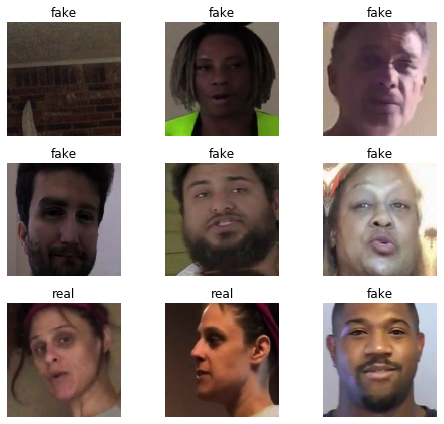

In [0]:
dataBunch.show_batch(rows=3, figsize=(7,6))

In [0]:
print(dataBunch.classes)

['fake', 'real']


In [0]:
load_learner()

In [0]:
learn = cnn_learner(dataBunch, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.5MB/s]


### resnet34

In [0]:
learn.fit_one_cycle(4)

### resnet50

In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.save('/content/drive/My Drive/DeepFakeDetection/models/fastai/resnet50_acc0.725')

In [0]:
learn.export('/content/drive/My Drive/DeepFakeDetection/models/fastai/resnet50_acc0.725_learner')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

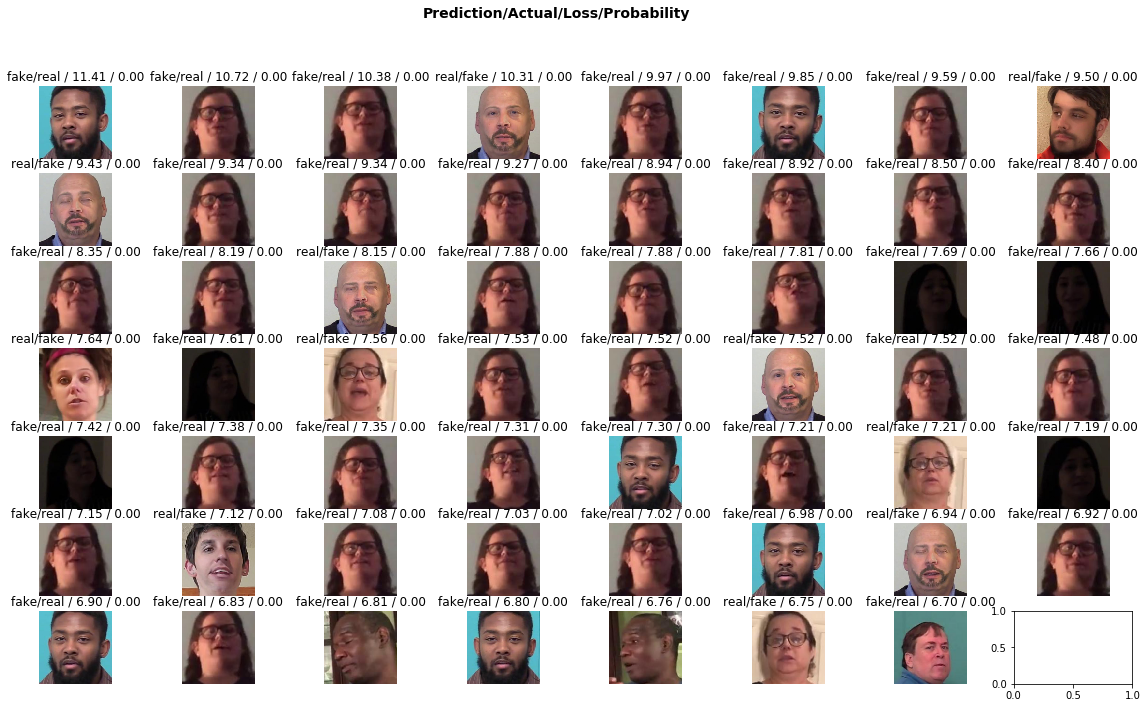

In [0]:
interp.plot_top_losses(55, figsize=(20,11))

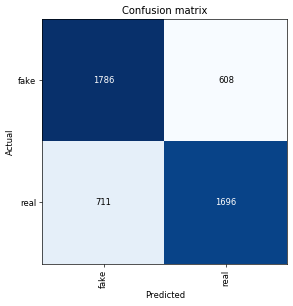

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [0]:
%cd train_

/content/drive/My Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real/train_


In [0]:
%cd fake

/content/drive/My Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real/train_/fake


In [0]:
for f in os.listdir():
    print(len(os.listdir(f)))

In [0]:
%cd /content/drive/My\ Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real
%ls

/content/drive/My Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real
models/  train/  train_/  validation/  validation_/


In [0]:
# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware
torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

These functions are specific for our dataset. 

We store images in a folder with the name of the video it belongs to. 
Example: `train/fake/133412/133412_1.jpg`


In [0]:
# We will get either "train" or "valid" for an image to split the ds correctly
def _grandgrandparent_idxs(items, name): return mask2idxs(Path(o).parent.parent.parent.name == name for o in items)

# This is a wrapper for the function defined above
def GrandGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandgrandparent_idxs(o, train_name),_grandgrandparent_idxs(o, valid_name)
    return _inner

In [0]:
# We will get either "fake" or "real" to label the image
def grandparent_label(o, **kwargs):
    "Label `item` with the parent folder name."
    return Path(o).parent.parent.name

These are basic parameters used in [this](https://github.com/ducha-aiki/imagewoofv2-fastv2-maxpoolblur/blob/master/fastai2-imagenette-train-maxblurpool.ipynb) notebook to create and train a fastai2 model:

In [0]:
#-lr 8e-3 --sqrmom 0.99 --mom 0.95 --eps 1e-6 --bs 64 --opt ranger --sa 1
#--fp16 1 --arch xse_resnext50 --pool MaxPool

In [0]:
os.listdir(data_dir)

['train_', 'train', 'validation', 'validation_']

Transforms that will be applied to every image and every batch.

`RandomResizedCrop` randomly scales an image with the scale ratio varying from `min_scale` to 1.0

`FlipItem` flips an image with the probability `p`.

`RandomErasing` randomly selects a rectangle region in an image and randomizes its pixels. 

In [0]:
item_tfms=[RandomResizedCrop(128, min_scale=0.85), FlipItem(p=0.5)]

# `max_count` is the number of holes in the image.
# `sh` is the highest bound for the scale of the rectangle (1. corresponds to a full-sized one)
batch_tfms=RandomErasing(p=0.9, max_count=3, sh=0.) 

This is very much like PyTorch Dataset.

As we have a 2-classification task, our basic blocks will be `ImageBlock` for images
and `CategoryBlock` for the two categories.
`get_image_files` will search for images in all the child directories of `path` recursively.

We use functions `GrandGrandparentSplitter` and `grandparent_label` defined above.

In [0]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandGrandparentSplitter(train_name='train_', valid_name='validation_'),
                  get_y=grandparent_label, item_tfms=item_tfms, batch_tfms = batch_tfms)


In [0]:
dls = dblock.dataloaders(data_dir)

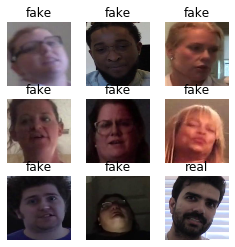

In [0]:
dls.show_batch(max_n=9, figsize=(4,4))

In [0]:
# monkey-patch so the next cell works correctly
Transform.name="Transform"

In [0]:
dblock.summary(data_dir)

Setting-up type transforms pipelines
Found 48106 items
2 datasets of sizes 43305,4801
Setting up Pipeline: (#2) [Transform: True (object,object) -> noop ,Transform: True (bytes,object) -> create
(ndarray,object) -> create
(Tensor,object) -> create
(str,object) -> create
(Path,object) -> create ]
Setting up Pipeline: (#2) [Transform: True (object,object) -> grandparent_label ,Categorize: True (object,object) -> encodes (object,object) -> decodes]

Building one sample
  Pipeline: (#2) [Transform: True (object,object) -> noop ,Transform: True (bytes,object) -> create
(ndarray,object) -> create
(Tensor,object) -> create
(str,object) -> create
(Path,object) -> create ]
    starting from
      /content/drive/My Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real/train_/fake/aatstfrpio/aatstfrpio_0_0.jpg
    applying Transform gives
      /content/drive/My Drive/DeepFakeDetection/data/NOTREADY_large_ds_500_Fake_500_Real/train_/fake/aatstfrpio/aatstfrpio_0_0.jpg
    applying Trans

In [0]:
# Parameters for our magic `ranger` optimizer
sqrmom=0.99
mom=0.95
eps=1e-6
beta=0.

opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [0]:
# Parameters for a `xse_resnext50` model with a magic `MishJit` activation
# DeepLearning uzhe ne tort
arch='xse_resnext50'
act_fn='MishJit'
pool='MaxPool'

m,act_fn,pool = [globals()[o] for o in (arch,act_fn,pool)]

In [0]:
sa=1 # Self-attention
sym=0 # Symmetry for self-attention
fp16 = 1 # Using mixed-precision training
model =  m(c_out=2, pretrained=True, act_cls=act_fn, sa=sa, sym=sym, pool=pool)

In [0]:
# fastai learner. 
# As soon as you create an instance of this, you can be sure that everything is alright
# Surprisingly, loss function is not `CrossEntropy` but `LabelSmoothingCrossEntropy`

learn = Learner(dls, model, opt_func=opt_func, \
                metrics=[accuracy], loss_func=LabelSmoothingCrossEntropy())

In [0]:
b = dls.train.one_batch()

In [0]:
# This adds mixed-precision
if fp16: learn = learn.to_fp16()

In [0]:
# finally
learn.fit_flat_cos(n_epoch=5, lr=8e-3, wd=1e-2, cbs=[])

In [0]:
# finally
learn.fit_flat_cos(n_epoch=5, lr=8e-3, wd=1e-2, cbs=[])

In [0]:
learn.get_preds(ds_idx = 1, dl = dls.valid, with_loss=True)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f892b3154a8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f892b3154a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
    assert self._p

(tensor([[0.9296, 0.0704],
         [0.9327, 0.0673],
         [0.9306, 0.0694],
         ...,
         [0.0503, 0.9497],
         [0.0633, 0.9367],
         [0.0659, 0.9341]]),
 TensorCategory([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0.2020, 0.2011, 0.2017,  ..., 0.1985, 0.2001, 0.2007]))

In [0]:
learn

In [0]:
learn.load('/content/drive/My Drive/DeepFakeDetection/models/fastai/model1_acc0.7.pkl')

We don't need the next cell yet

## Build submission

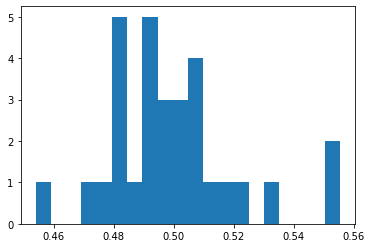

In [0]:
submission = pd.DataFrame(submission, columns=['filename', 'label'])
submission.sort_values('filename').to_csv('submission.csv', index=False)

plt.hist(submission.label, 20)
plt.show()